In [1]:
import os
os.chdir(r'/Users/zhanghui/商业分析工具和应用/Python/Python_book/10ANN')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
churn = pd.read_csv('telecom_churn.csv')
churn.head()

,subscriberID,churn,gender,AGE,edu_class,incomeCode,duration,feton,peakMinAv,peakMinDiff,posTrend,negTrend,nrProm,prom,curPlan,avgplan,planChange,posPlanChange,negPlanChange,call_10000
0,19164958,1,0,20,2,12,16,0,113.666667,-8.0,0,1,0,0,1,1,0,0,0,0
1,39244924,1,1,20,0,21,5,0,274.000000,-371.0,0,1,2,1,3,2,2,1,0,1
2,39578413,1,0,11,1,47,3,0,392.000000,-784.0,0,1,0,0,3,3,0,0,0,1
3,40992265,1,0,43,0,4,12,0,31.000000,-76.0,0,1,2,1,3,3,0,0,0,1
4,43061957,1,1,60,0,9,14,0,129.333333,-334.0,0,1,0,0,3,3,0,0,0,0


In [6]:
#使用scikit-learn中的train_test_split函数划分训练集和测试集
from sklearn.model_selection import train_test_split

data = churn.iloc[:,2:]
target = churn['churn']
train_data,test_data,train_target,test_target = train_test_split(
data,target,test_size = 0.4,train_size=0.6,random_state = 1234)

In [7]:
#极差标准化
#连续变量进行极差标准化，等级变量和分类变量可以当作连续变量处理，
#多分类变量需要转变为虚拟变量

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)

scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)


In [9]:
#模型训练
#引入多重感知器，先设定一个隐藏层，10个神经元，使用logistic激活函数（sigmoid函数）
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes = (10,),
                   activation = 'logistic', alpha = 0.1, max_iter = 1000)
mlp.fit(scaled_train_data,train_target)

MLPClassifier(activation='logistic', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [10]:
#模型预测
train_predict = mlp.predict(scaled_train_data)
test_predict = mlp.predict(scaled_test_data)

In [11]:
#计算分别属于各类的概率，取标签为1的概率
train_proba = mlp.predict_proba(scaled_train_data)[:,1]
test_proba = mlp.predict_proba(scaled_test_data)[:,1]

In [12]:
#模型评估-混淆矩阵
from sklearn import metrics
print(metrics.confusion_matrix(test_target,test_predict,labels = [0,1]))


[[640 136]
 [100 510]]


In [13]:
print(metrics.classification_report(test_target,test_predict))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       776
           1       0.79      0.84      0.81       610

    accuracy                           0.83      1386
   macro avg       0.83      0.83      0.83      1386
weighted avg       0.83      0.83      0.83      1386



In [14]:
mlp.score(scaled_test_data,test_target)#mean accuracy

0.8297258297258298

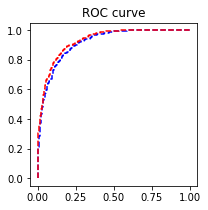

0.9144182017914484


In [23]:
#ROC评估-结果显示，准确度很高，没有过拟合
fpr_test,tpr_test,th_test = metrics.roc_curve(test_target,test_proba)
fpr_train,tpr_train,th_train = metrics.roc_curve(train_target,train_proba)

plt.figure(figsize = [3,3])
plt.plot(fpr_test,tpr_test,'b--')
plt.plot(fpr_train,tpr_train,'r--')
plt.title('ROC curve')
plt.show()
print(metrics.roc_auc_score(test_target,test_proba))

最优参数搜索：GridSearchCV

In [27]:
#使用模型隐藏数量，激活函数，正则化系数三个参数来构建参数搜索网格，选择roc_auc评判，4折交叉验证
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

param_grid = {
    'hidden_layer_sizes':[(10,),(15,),(20,),(5,5)],
    'activation':['logistic','tanh','relu'],
    'alpha':[0.001,0.01,0.1,0.2,0.4,1,10]
    
}

mlp = MLPClassifier(max_iter = 1000)
gcv = GridSearchCV(estimator = mlp, param_grid = param_grid,
                   scoring = 'roc_auc',cv=4,n_jobs = -1)
gcv.fit(scaled_train_data,train_target)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=1000,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu']

In [28]:
gcv.best_score_

0.9262365195911655

In [29]:
gcv.best_params_

{'activation': 'relu', 'alpha': 0.2, 'hidden_layer_sizes': (5, 5)}

In [30]:
gcv.score(scaled_test_data,test_target)

0.916822291701876